In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Create dataset
The model will expect 12 datapoints, i.e. one year of data, to predict the amount of passengers for the next month

In [2]:
flight_data = sns.load_dataset("flights")
flight_data

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121
...,...,...,...
139,1960,August,606
140,1960,September,508
141,1960,October,461
142,1960,November,390


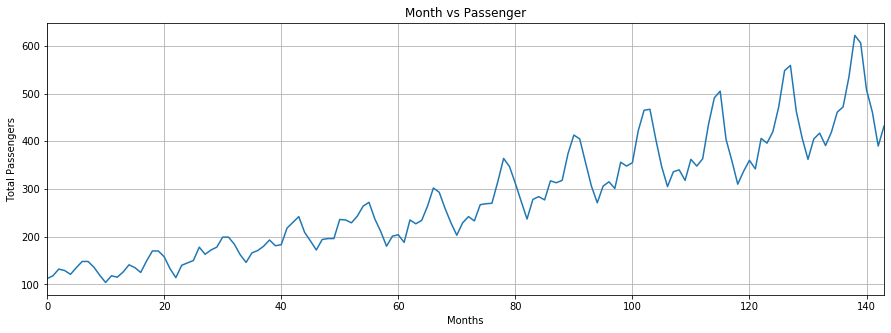

In [3]:
plt.figure(figsize=(15,5))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [4]:
all_data = flight_data['passengers'].values.astype(float)

In [5]:
test_data_size = 24

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [6]:
def create_inout_sequences(input_data, winow):
    X = []
    y = []
    for i in range(len(input_data)-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window]
        X.append(train_seq)
        y.append(train_label)
    return torch.FloatTensor(X), torch.FloatTensor(y)

In [7]:
window = 12
X_train, y_train = create_inout_sequences(train_data, window)
X_test, y_test = create_inout_sequences(test_data, window)

In [8]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4)

## Create and train the model
A simple LSTM model is chosen. The model expects a list of inputs to predict which is in line with the best practices to upload your model.

In [9]:
import torch
import torch.nn as nn

class PassengerModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(1, x.size(0), self.hidden_layer_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_layer_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x.view(x.size(0), x.size(1), 1).float(), (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out.flatten()

In [10]:
model = PassengerModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 2000

for i in range(epochs):
    running_loss = 0.0
    for j, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if i%100 == 0:
        print(f'epoch: {i:3} loss: {running_loss/len(train_loader):10.8f}')
    running_loss = 0.0

print(f'epoch: {i:3} loss: {loss.item():10.10f}')

epoch:   0 loss: 74523.93055556
epoch: 100 loss: 13492.22694030
epoch: 200 loss: 5287.44920858
epoch: 300 loss: 1590.05039243
epoch: 400 loss: 824.22931134
epoch: 500 loss: 687.21252526
epoch: 600 loss: 624.78486591
epoch: 700 loss: 540.86834999
epoch: 800 loss: 441.66759208
epoch: 900 loss: 630.79070508
epoch: 1000 loss: 416.98121827
epoch: 1100 loss: 329.70298216
epoch: 1200 loss: 247.37468451
epoch: 1300 loss: 277.18359318
epoch: 1400 loss: 298.75807487
epoch: 1500 loss: 340.92417032
epoch: 1600 loss: 188.48146891
epoch: 1700 loss: 140.08797165
epoch: 1800 loss: 94.94068513
epoch: 1900 loss: 62.34457419
epoch: 1999 loss: 137.1528015137


## Check if the model learned something

In [12]:
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [13]:
preds = []
for i, (x, y) in enumerate(test_loader):
    with torch.no_grad():
        preds.extend(model(x).tolist())


In [14]:
x = np.arange(132, 144, 1) # x for the predicted points

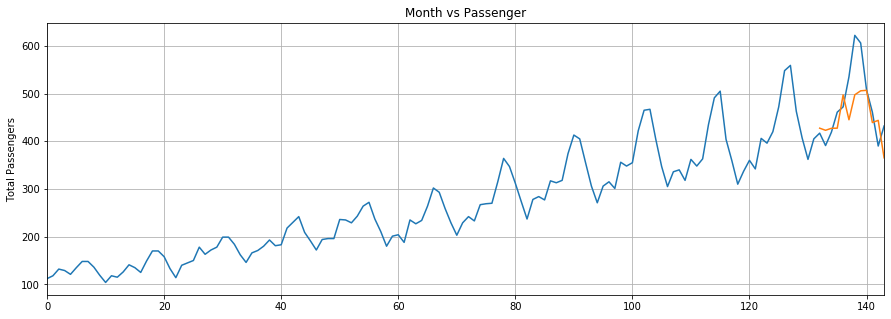

In [15]:
plt.figure(figsize=(15,5))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,preds)
plt.show()

## Save the model using TorchScript
For more information, check https://pytorch.org/docs/stable/jit.html#torch.jit.save

In [16]:
example_input = test_dataset[:4][0]
example_input

tensor([[360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.],
        [342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405., 417.],
        [406., 396., 420., 472., 548., 559., 463., 407., 362., 405., 417., 391.],
        [396., 420., 472., 548., 559., 463., 407., 362., 405., 417., 391., 419.]])

In [17]:
traced_cell = torch.jit.trace(model, example_input)
torch.jit.save(traced_cell, "model.pt")

## Upload the model to the Waylay platform

In [18]:
from zipfile import ZipFile
from io import BytesIO
import requests
from requests.auth import HTTPBasicAuth
def upload_model(model_name, description, upload_url, api_key, api_secret):
    
    zipfile_name = 'model.zip'
    # Create a zip
    with ZipFile(zipfile_name, 'w') as zipfile:
        zipfile.write('model.pt')
        
    with open(zipfile_name, 'rb') as f:
        upload_file = BytesIO(f.read())
        
    # upload to waylay
    resp = requests.post(upload_url,
                         files={"file": (zipfile_name, upload_file)},
                         data={"name": model_name, 
                               "framework": "pytorch", 
                               "description": description,
                              },
                         auth=HTTPBasicAuth(api_key, api_secret))

    return resp.json()

In [19]:
# https://docs.waylay.io/api/rest/#authentication
api_key = 'your api key'
api_secret = 'your api secret'
byoml_url = 'https://byoml.waylay.io/models'
model_name = 'passenger-prediction'
description = 'A model that predicts passenger count given the passenger counts of the previous year (12 datapoints)'
upload_model(model_name, description, byoml_url, api_key, api_secret)

{'message': 'Model successfully uploaded'}

## Check if the uploaded and the local model give the same output

In [20]:
instances = test_dataset[4:][0] 
instances

tensor([[420., 472., 548., 559., 463., 407., 362., 405., 417., 391., 419., 461.],
        [472., 548., 559., 463., 407., 362., 405., 417., 391., 419., 461., 472.],
        [548., 559., 463., 407., 362., 405., 417., 391., 419., 461., 472., 535.],
        [559., 463., 407., 362., 405., 417., 391., 419., 461., 472., 535., 622.],
        [463., 407., 362., 405., 417., 391., 419., 461., 472., 535., 622., 606.],
        [407., 362., 405., 417., 391., 419., 461., 472., 535., 622., 606., 508.],
        [362., 405., 417., 391., 419., 461., 472., 535., 622., 606., 508., 461.],
        [405., 417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.]])

In [21]:
model(instances)

tensor([497.1295, 445.0429, 497.4133, 505.7504, 506.7740, 439.2025, 443.7865,
        365.2272], grad_fn=<ViewBackward>)

In [22]:
requests.post(byoml_url + '/' + model_name + '/predict',
              json = {"instances": instances.tolist()},
              auth=HTTPBasicAuth(api_key, api_secret)).json()

{'predictions': [497.1294250488281,
  445.0428771972656,
  497.4132995605469,
  505.7503967285156,
  506.7739562988281,
  439.2025451660156,
  443.7865295410156,
  365.2272033691406]}

## More advanced TorchScript
In the example above we uploaded the model straight away, but if we want to add some pre- or postprocessing, we can also use TorchScript for this. In the example above, each input was a shift of the previous one with a new value added. It would be better if we can just feed a list of values to the model, so we do not duplicate the information. This is done in the example below:

It expects again a list of inputs, where each input is just a list of values (length does not matter). It will split this list into sublists of length 12 (one year of data), and feed it the to model. For the sake of this example we also added the length of inputs the model got to the output. 

Keep in mind this did not change anything to the model itself, so if we feed the data above to this model (but in a flattened list) we should get the same output.

In [23]:
class MyScriptModule(torch.jit.ScriptModule):
    def __init__(self):
        super(MyScriptModule, self).__init__()
        self.model = torch.jit.trace(model, example_input)
        self.window = window

    @torch.jit.script_method
    def forward(self, inputs):
        predictions: List[Tuple[int, Tensor]] = [] # our output list
            
        # Again a best practice, accept a list of inputs, where each out will be one object, 
        # belonging to the input with the same index:
        # in this case a number and a list of predictions.
        for tensor_list in inputs:
            model_inputs = []
            
            # split into sublists of length 12
            for i in range(tensor_list.shape[0] - self.window):
                model_inputs.append(tensor_list[i:i+self.window])
                
            # append the outcome of the prediction together with the length to the predict list
            predictions.append((len(model_inputs), self.model(torch.stack(model_inputs))))
            
        return predictions

In [24]:
script_model = MyScriptModule()

In [25]:
script_model.save('model.pt')

In [26]:
script_model_name = 'passenger-model-script'
script_description = \
'A model that predicts passenger count given the passenger counts of the previous year (12 datapoints). '
'Input is just a list of number that will be splits into sublists of 12 numbers.'

upload_model(script_model_name, script_description, byoml_url, api_key, api_secret)

{'message': 'Model successfully uploaded'}

## Check again if the output is the same
Except for the added length the model will output, the predictions should be the same.

In [27]:
script_input = torch.tensor([test_data[4:]])
script_input

tensor([[420., 472., 548., 559., 463., 407., 362., 405., 417., 391., 419., 461.,
         472., 535., 622., 606., 508., 461., 390., 432.]], dtype=torch.float64)

In [28]:
script_model(script_input)

[(8,
  tensor([497.1295, 445.0429, 497.4133, 505.7504, 506.7740, 439.2025, 443.7865,
          365.2272], grad_fn=<ViewBackward>))]

In [29]:
requests.post(byoml_url + '/' + script_model_name + '/predict',
              json = {"instances": script_input.tolist()},
              auth=HTTPBasicAuth(api_key, api_secret)).json()

{'predictions': [[8,
   [497.1294250488281,
    445.0428771972656,
    497.4132995605469,
    505.7503967285156,
    506.7739562988281,
    439.2025451660156,
    443.7865295410156,
    365.2272033691406]]]}

## Delete the created models

In [30]:
requests.delete(byoml_url + '/' + model_name,
                auth=HTTPBasicAuth(api_key, api_secret)).json()

{'message': 'Model successfully deleted'}

In [31]:
requests.delete(byoml_url + '/' + script_model_name,
                auth=HTTPBasicAuth(api_key, api_secret)).json()

{'message': 'Model successfully deleted'}